In [8]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.proxy import Proxy, ProxyType

from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
from selenium.webdriver.firefox.options import Options

from multiprocessing import Pool

import requests
import time
import re
import csv
import os

PATH = os.path.abspath(os.curdir) + '/geckodriver'
HOST = 'https://www.reformagkh.ru/myhouse'
SECS = 5
#PROXY = '139.5.135.37:5678'

options = webdriver.FirefoxOptions()
#options.add_argument("--headless")
#options.add_argument('--proxy-server=socks4://' + PROXY)
URL = "https://www.reformagkh.ru/myhouse?tid=2208161"

In [9]:
def get_html_page(url):
    try:
        driver = webdriver.Firefox(
            executable_path = PATH,
            options=options)
        driver.get(url=url)
        time.sleep(SECS)    
        html_page = driver.page_source
        return(html_page)
    except Exception as ex:
        print(ex)
    finally:
        driver.close()
        driver.quit()

In [3]:
def get_suffixes(html_page):
    soup = BeautifulSoup(html_page, 'html')
    a_class = soup.find_all('a')
    href=[]
    for suffix in a_class:
        suffix = suffix.get('href')
        if suffix is not None:
            href.append(suffix)
    feature_suffixes = full_link([item for item in href if re.findall('tid+.\d+', item)])
    return(feature_suffixes)

In [4]:
def full_link(href_suffixes):
    feature_links = [HOST + suffix for suffix in href_suffixes]
    return(feature_links)

In [5]:
def get_max_pages(url):
    gorod = get_html_page(url)
    soup = BeautifulSoup(gorod, 'html')
    a_class = soup.find_all('a')
    number = []
    
    num_of_pages = soup.find_all('a', class_='page-link')
    for suffix in num_of_pages:
        suffix = suffix.get('data-page')
        if suffix is not None:
            number.append(suffix)
    max_pages = int(suffix) # последнее полученное число и есть максимальное число страниц
    return(max_pages)

In [6]:
def get_all_houses(url): 
    max_pag = get_max_pages(url)
    driver = webdriver.Firefox(
            executable_path = PATH,
            options=options)
    driver.get(url)
    time.sleep(SECS)    # Время обработки адреса
    href = []
    # Из-за особенностей сайта выводим второе окно в браузере
    for i in range(max_pag):
        driver.execute_script("window.open('about:blank', 'tab2')")
        driver.switch_to.window("tab2")
        driver.get(HOST + '?' + 'page=' + str(i+1) + '&limit=20&view=list&sort=name&order=asc')
        time.sleep(SECS)
        html_page = driver.page_source
        soup = BeautifulSoup(html_page,'html')
        a_class = soup.find_all('a')
        for suffix in a_class:
            suffix = suffix.get('href')
            if suffix is not None:
                suffix = 'https://www.reformagkh.ru' + suffix
                href.append(suffix)
    feature_suffixes = [item for item in href if re.findall('view+.\d+', item)]
    driver.close()
    driver.quit()
    return(feature_suffixes)

In [7]:
def get_house_data(house_url):
    a = []
    b = []    # Незнание "знания списков"
    c = []
    data = {'Адрес':'None',
            'Общая площадь, кв.м':'None',
            'Общая площадь жилых помещений, кв.м':'None',
            'Количество этажей, ед.':'None',
            'Количество подъездов, ед.':'None',
            'Количество жилых помещений':'None',
            'Количество лифтов, ед.': 'None',
            'Факт признания дома аварийным':'None',
            'Год ввода дома в эксплуатацию':'None',
            'Численность жителей, чел.':'None'}
    
    house_page = get_html_page(house_url) # поменять на реквест
    soup = BeautifulSoup(house_page, 'html')
    address = soup.find_all('h2')
    house_address = address[0].get_text()
    house_address = house_address.replace(',',';')
    
    features = soup.find_all('div', class_='house-specs d-flex fw-600 f-14 lh-19 align-items-start mb-3')
    house_data = [item.get_text() for item in features]
    
    # Преобразование полученных данных в приемлемый для обработки вид
    for i in house_data:
        a.append(i.replace(',','.').replace(' ',''))
    for iter in a:
        nums = re.findall(r'\d*\.\d+|\d+', iter)
        nums = [float(i) for i in nums]
        b = b + nums
    for i in house_data:    
        m = re.search('\n(.+?)\n', i)
        if m:
            found = m.group(1)
        c.append(found)
    
    dictionary = dict(zip(c, b))    
    dictionary["Адрес"] = house_address
    data.update(dictionary)# Склеиваем два словаря так, чтобы словарь со значением дома шёл поверх пустого словаря
    return(data)

In [8]:
def save_file(house_data_list):
    with open('houses.csv', 'w', newline = '') as file:
        writer = csv.writer(file, delimiter = ';')
        writer.writerow(["Адрес", 
                         "Общая площадь кв.м", 
                         "Общая площадь жилых помещений кв.м", 
                         "Количество этажей",
                         "Количество подъездов", 
                         "Количество жилых помещений",
                         "Количество лифтов",
                         "Факт признания дома аварийным",
                         "Год ввода дома в эксплуатацию",
                         "Численность жителей"])
        for item in house_data_list:
            writer.writerow([item["Адрес"],
                             item["Общая площадь, кв.м"],
                             item["Общая площадь жилых помещений, кв.м"],
                             item["Количество этажей, ед."],
                             item["Количество подъездов, ед."],
                             item["Количество жилых помещений"],
                             item["Количество лифтов, ед."],
                             item["Факт признания дома аварийным"],
                             item["Год ввода дома в эксплуатацию"],
                             item["Численность жителей, чел."]])

In [9]:
def all_links():
    main_page = get_html_page(URL)
    oblast_links = get_suffixes(main_page)
    return(oblast_links)

In [17]:
def parse(oblast_links):
    i = 0
    house_datas = []
    all_selsovet_list = []
    try:
        print(oblast_links)
        oblast_html = get_html_page(oblast_links)
        oblast_inside_links = get_suffixes(oblast_html)
        for rayon_or_gorod in oblast_inside_links[1:]:    # Из-за особенностей вложенности домов парсим города и районы отдельно
            try:
                rayon_html_page = get_html_page(rayon_or_gorod)    # Обработка всех районов
                selsovet_links = get_suffixes(rayon_html_page)
                for selsovet_link in selsovet_links[2:]:
                    try:
                        selsovet_house_links = get_all_houses(selsovet_link)
                        all_selsovet_list += selsovet_house_links
                        for rayon_house in all_selsovet_list[3:]:
                            rayon_house_dict = get_house_data(rayon_house)
                            house_datas.append(rayon_house_dict)
                            save_file(house_datas)
                    except:
                        i += 1
            except:                                                # В ином случае обработка городов
                try:
                    gorod_houses_links = get_all_houses(rayon_or_gorod)
                    for gorod_house in gorod_houses_links:
                        gorod_house_dict = get_house_data(gorod_house)
                        house_datas.append(gorod_house_dict)
                        save_file(house_datas)
                except:
                    i += 1
    except:
            i += 1
    save_file(house_datas)
    print("Число неправильно сформированных адресов: " + str(i))

In [13]:
parse()

Message: Malformed URL: URL constructor: h is not a valid URL.

Message: Malformed URL: URL constructor: h is not a valid URL.

Message: Malformed URL: URL constructor: h is not a valid URL.

Message: Malformed URL: URL constructor: h is not a valid URL.



TypeError: object of type 'NoneType' has no len()

In [12]:
oblast_links = all_links()

In [14]:
oblast_links[1:]

['https://www.reformagkh.ru/myhouse?tid=2208163',
 'https://www.reformagkh.ru/myhouse?tid=2215422',
 'https://www.reformagkh.ru/myhouse?tid=2216073',
 'https://www.reformagkh.ru/myhouse?tid=2220005',
 'https://www.reformagkh.ru/myhouse?tid=2220463',
 'https://www.reformagkh.ru/myhouse?tid=2222089',
 'https://www.reformagkh.ru/myhouse?tid=2224825',
 'https://www.reformagkh.ru/myhouse?tid=2227349',
 'https://www.reformagkh.ru/myhouse?tid=2228920',
 'https://www.reformagkh.ru/myhouse?tid=2236864',
 'https://www.reformagkh.ru/myhouse?tid=2280999',
 'https://www.reformagkh.ru/myhouse?tid=2276347',
 'https://www.reformagkh.ru/myhouse?tid=2399515',
 'https://www.reformagkh.ru/myhouse?tid=2361205',
 'https://www.reformagkh.ru/myhouse?tid=2333436',
 'https://www.reformagkh.ru/myhouse?tid=2243734',
 'https://www.reformagkh.ru/myhouse?tid=2246043',
 'https://www.reformagkh.ru/myhouse?tid=2347352',
 'https://www.reformagkh.ru/myhouse?tid=2247652',
 'https://www.reformagkh.ru/myhouse?tid=2258331',


In [15]:
parse(oblast_links)

Число неправильно сформированных адресов: 7


In [1]:
def kek(url):
    html_code = get_html_page(url)
    print(html_code)

In [2]:
urls = ['https://vk.com/feed', 'https://www.google.com/search?channel=fs&client=ubuntu&q=facebook', 'https://ok.ru/']

<html itemscope="" itemtype="http://schema.org/SearchResultsPage" lang="ru"><head><meta charset="UTF-8"><meta content="origin" name="referrer"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>facebook - Поиск в Google</title><script src="https://apis.google.com/_/scs/abc-static/_/js/k=gapi.gapi.en.7RphtNcGHDQ.O/m=gapi_iframes,googleapis_client/rt=j/sv=1/d=1/ed=1/rs=AHpOoo_-zmYhp_Ir7_CCxM3l-AckMvaI9A/cb=gapi.loaded_0" nonce="SNlGjsgy+oMivqYDUl25eA==" async=""></script><script nonce="SNlGjsgy+oMivqYDUl25eA==">(function(){window.google={kEI:'fGwiYa7JMYOUxc8P9eyD6Aw',kEXPI:'31',kBL:'8pO8'};google.sn='web';google.kHL='ru';})();(function(){
var f=this||self;var h,k=[];function l(a){for(var b;a&&(!a.getAttribute||!(b=a.getAttribute("eid")));)a=a.parentNode;return b||h}function m(a){for(var b=null;a&&(!a.getAttribute||!(b=a.getAttribute("leid")));)a=a.parentNode;return b}
function n(a,b,c,d,g){var e="";c||-1!==b.search("&ei=")||(e="&ei="+l(d)
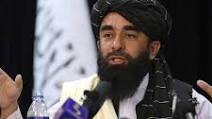
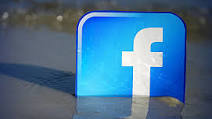
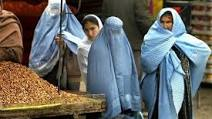
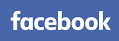
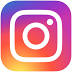
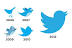
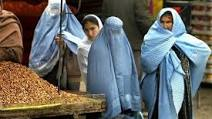

;});})();(function(){google.drty&&google.drty();})();});</script><div></div><div id="lfootercc"><script nonce="SNlGjsgy+oMivqYDUl25eA==">(function(){for(var i in google.iir||{}){_setImagesSrc([i],google.iir[i]);}google.iir={};})();</script><div id="reviewDialog" data-async-context="async_id_prefix:" data-jiis="up" data-async-type="reviewDialog" data-async-context-required="async_id_prefix" class="yp"></div><div id="dbg_"></div></div><script src="/xjs/_/js/k=xjs.s.ru.I_N3inRWqpg.O/am=QmQACAAAAAAAwB8A9AAZChcEAgAAAIwBAQAAAAAAgAAAAYm7iQsAABBgo8xLAAMAACAABQGYQwCQBhQRQRAAAABgBDoAzh8AgEfgEh4AAAAAAAAEoCUwQwUkAgIQAAAAAMRqQVUfEABABA/d=1/ed=1/dg=2/rs=ACT90oGLvYGLM3N5QQsvui7qQWJd7FBrlg/m=attn,cdos,cr,dpf,hsm,jsa,d,csi" nonce="SNlGjsgy+oMivqYDUl25eA=="></script><script src="/xjs/_/js/k=xjs.s.ru.I_N3inRWqpg.O/ck=xjs.s.4fah5u2vRDk.L.F4.O/am=QmQACAAAAAAAwB8A9AAZChcEAgAAAIwBAQAAAAAAgAAAAYm7iQsAABBgo8xLAAMAACAABQGYQwCQBhQRQRAAAABgBDoAzh8AgEfgEh4AAAAAAAAEoCUwQwUkAgIQAAAAAMRqQVUfEABABA/d=1/exm=attn,cdos,c

</body></html>
<html class=" anonym__rich anonym__feed anonym__wide visual__summer gecko nottouch small-toolbar white-toolbar" prefix="og: http://ogp.me/ns# video: http://ogp.me/ns/video# ya: http://webmaster.yandex.ru/vocabularies/" lang="en"><head><!-- META START --><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"><meta http-equiv="X-UA-Compatible" content="IE=edge"><title>OK social network. Communication with friends on OK. Your meeting place with classmates</title><meta http-equiv="Cache-Control" content="no-cache"><meta http-equiv="Pragma" content="no-cache"><meta http-equiv="Expires" content="Mon, 26 Jul 1997 05:00:00 GMT"><meta name="referrer" content="origin"><meta name="referrer" content="no-referrer-when-downgrade"><meta name="viewport" content="width=1024"><meta name="skype_toolbar" content="skype_toolbar_parser_compatible"><meta name="title" content="OK social network. Communication with friends on OK. Your meeting place with classmates"><meta name="descri

<div id="hook_Block_ShortcutMenu"></div></body></html>


In [14]:
if __name__ == '__main__':# тут чето заработало, поэтому попробовать с реформами сделать то же самое
    with Pool(2) as pool:
        pool.map(kek, urls)

In [15]:
oblasti = ['https://www.reformagkh.ru/myhouse?tid=2208163', 'https://www.reformagkh.ru/myhouse?tid=2215422']
if __name__ == '__main__':
    with Pool(2) as pool:
        data = pool.map(parse, oblast_links[1:])

Остановились на: https://www.reformagkh.ru/myhouse?tid=2208163
Остановились на: https://www.reformagkh.ru/myhouse?tid=2208163
Остановились на: https://www.reformagkh.ru/myhouse?tid=2208163
Остановились на: https://www.reformagkh.ru/myhouse?tid=2208163
Остановились на: https://www.reformagkh.ru/myhouse?tid=2276347
Остановились на: https://www.reformagkh.ru/myhouse?tid=2276347
Остановились на: https://www.reformagkh.ru/myhouse?tid=2208163
Остановились на: https://www.reformagkh.ru/myhouse?tid=2208163
Остановились на: https://www.reformagkh.ru/myhouse?tid=2276347
Остановились на: https://www.reformagkh.ru/myhouse?tid=2208163
Остановились на: https://www.reformagkh.ru/myhouse?tid=2276347
Остановились на: https://www.reformagkh.ru/myhouse?tid=2276347
Остановились на: https://www.reformagkh.ru/myhouse?tid=2276347
Остановились на: https://www.reformagkh.ru/myhouse?tid=2276347
Остановились на: https://www.reformagkh.ru/myhouse?tid=2276347
Остановились на: https://www.reformagkh.ru/myhouse?tid=

KeyboardInterrupt: 